# Fun with maps, part 2

After some map images have been picked from random locations in the map service, we can filter out images that are not in the area of interest.

## Dependencies

In [ ]:
using System.IO;
using System.Drawing;

using static Microsoft.DotNet.Interactive.Formatting.PocketViewTags;

var random = new Random();

## Step 2: Filter images

Remove _mostly blank_ images. Relevant images will be stored in the `output/step2` folder.

### List of images from Step 1

In [ ]:
var sourceImageFolder = "output/step1";

var sourceImages = Directory.GetFiles(sourceImageFolder).Where(file => file.EndsWith("png")).ToList();

display($"{sourceImages.Count} source images found, displaying name of first 10");
display(sourceImages.Take(10));

72 source images found, displaying name of first 10

index,value
0,output/step1\10__-11.588798300840637__-68.68339843761547.png
1,output/step1\10__-152.06833942846592__64.34115459801083.png
2,output/step1\10__-162.33435150395684__-72.86250875426043.png
3,output/step1\10__-32.24868990719892__-44.24368690855826.png
4,output/step1\10__-42.04701322217619__73.87894852429855.png
5,output/step1\10__104.25148700917953__4.575498559456321.png
6,output/step1\10__171.86509488204103__-27.829455715852127.png
7,output/step1\10__33.20954388098079__35.92207931344612.png
8,output/step1\10__49.32387492234463__24.184973464073778.png
9,output/step1\10__79.48045625501157__-25.971141768261305.png


### Read pixel values from image

Use of `System.Drawing.Bitmap` to read the pixel values from the image is for simplicity. A more efficient/portable way could be to use alternatives like _SkiaSharp_ or _ImageSharp_, as suggested in [this article](https://devblogs.microsoft.com/dotnet/net-core-image-processing/).

In [ ]:
var someImage = sourceImages.Skip(random.Next(sourceImages.Count)).First();

var bitmap = new System.Drawing.Bitmap(someImage);

IEnumerable<Color> GetColors(Bitmap bitmap)
{
	for (int x = 0; x < bitmap.Width; x++)
	{
		for (int y = 0; y < bitmap.Height; y++)
		{
			yield return bitmap.GetPixel(x, y);
		}
	}
}

(IEnumerable<byte> reds, IEnumerable<byte> greens, IEnumerable<byte> blues) GetColorChannels(IEnumerable<Color> colors)
{
	var list = colors.ToList();
	var reds = list.Select(color => color.R);
	var greens = list.Select(color => color.G);
	var blues = list.Select(color => color.B);

	return (reds, greens, blues);
}

var (reds, greens, blues) = GetColorChannels(GetColors(bitmap));

output/step1\10__-162.33435150395684__-72.86250875426043.png Reds: 146, 146, 146, 146, 146, 146, 146, 146, 146, 146... Blues: 230, 230, 230, 230, 230, 230, 230, 230, 230, 230... Greens: 199, 199, 199, 199, 199, 199, 199, 199, 199, 199...
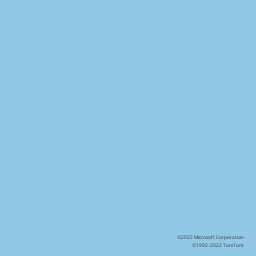

In [ ]:
display(
	table(
		caption(someImage),
		tr(
			td[rowspan: 3](img[src: "data:image/png;base64," + Convert.ToBase64String(File.ReadAllBytes(someImage)), width: "50%"]),
			td($"Reds: {string.Join(", ", reds.Take(10))}...")
		),
		tr(
			td($"Blues: {string.Join(", ", blues.Take(10))}...")
		),
		tr(
			td($"Greens: {string.Join(", ", greens.Take(10))}...")
		)
	)
)

### Detect _mostly blank_ images

We can use the standard deviation of all three color channels to detect _mostly blank_ images. Mostly uniform images will have a standard deviation close to 0 for all color channels. This method is not perfect, but has the advantage to handle compression artifacts well (compression can cause small variations on very similar colors).

.NET Core does not come with a standard deviation function, so we use an implementation based on [this approach](https://www.strchr.com/standard_deviation_in_one_pass) and [this StackOverflow](https://stackoverflow.com/a/19370637) answer.

In [ ]:
double std_var (byte[] a) {
	if (a.Length == 0) return 0;
	double sum = 0;
	double sq_sum = 0;
	for(int i = 0; i < a.Length; ++i) {
		int ai = a[i];
		sum += ai;
		sq_sum += ai * ai;
	}
	double N = a.Length;
	return (N * sq_sum - sum * sum) / (N * N);
}

Actually it is the variance that is being computed, but this will perfectly do in this case (the standard deviation is the square root of the variance).

Red variance 5.816422488540411 Blue variance 14.632977213477716 Green variance 10.907840725034475
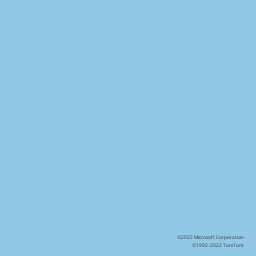

Red variance 5.816422488540411 Blue variance 14.632977213477716 Green variance 10.907840725034475
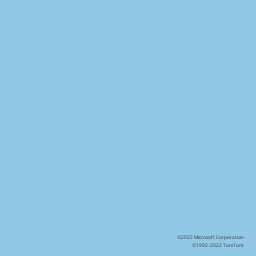

Red variance 16.08935211203061 Blue variance 16.26194459735416 Green variance 16.08935211203061
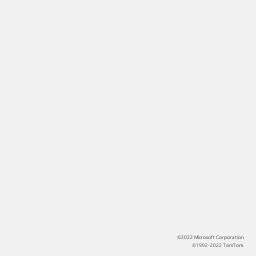

Red variance 13.864788127830252 Blue variance 14.252662658458576 Green variance 15.685620231321082
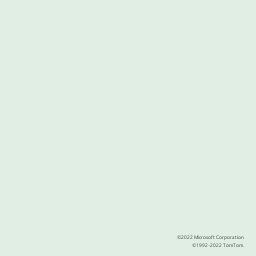

Red variance 636.0690686868038 Blue variance 252.1047284603119 Green variance 329.60797397699207
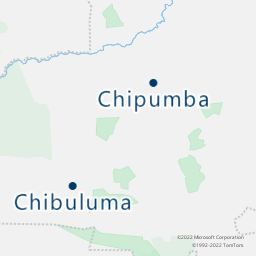

In [ ]:
var randomImages = sourceImages.OrderBy(file => random.Next()).Take(5);

var imagesWithVariance = randomImages
	.Select(imageFile => {
		var colorChannels = GetColorChannels(GetColors(new Bitmap(imageFile)));
		return new {
			file = imageFile,
			redVariance = std_var(colorChannels.reds.ToArray()),
			greenVariance = std_var(colorChannels.greens.ToArray()),
			blueVariance = std_var(colorChannels.blues.ToArray())
		};
	});

imagesWithVariance.ToList().ForEach(
	image => display(
		table(
			tr(
				td[rowspan: 3](img[src: "data:image/png;base64," + Convert.ToBase64String(File.ReadAllBytes(image.file)), width: "50%"]),
				td("Red variance"),
				td(image.redVariance)
			),
			tr(
				td("Blue variance"),
				td(image.blueVariance)
			),
			tr(
				td("Green variance"),
				td(image.greenVariance)
			)
		)
	));

### Save filtered images

If all three color channels have a variance below a defined threshold, the image is _mostly blank_ and can be discarded.

The threshold is somewhat arbitrary, but it seems to work well given the source data and considering that
- it is compared against the variance of each channel
- there is a small watermark at the bottom right of each image

In [ ]:
var outputImageFolder = "output/step2";

public bool IsBlank(string imageFile, double threshold) {
	var colorChannels = GetColorChannels(GetColors(new Bitmap(imageFile)));
	return new [] { colorChannels.reds, colorChannels.greens, colorChannels.blues }
		.All(channel => std_var(channel.ToArray()) < threshold);
}

sourceImages
	.Where(imageFile => !IsBlank(imageFile, threshold))
	.ToList()
	.ForEach(
		imageFile => File.Copy(imageFile, Path.Combine(outputImageFolder, Path.GetFileName(imageFile)), overwrite: true)
	);